In [1]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [9]:
df = pd.read_csv('MUL.BO.csv')

In [10]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-27,10.20,10.71,10.15,10.71,10.704762,516930.0
1,2017-01-30,11.24,11.24,11.24,11.24,11.234501,1000.0
2,2017-01-31,11.80,11.80,11.80,11.80,11.794228,1.0
3,2017-02-01,12.39,12.39,12.39,12.39,12.383939,1.0
4,2017-02-02,12.39,12.39,12.39,12.39,12.383939,0.0


In [11]:
# Extract "Date" and "Close" feature colums from the dataframe. 
df = df[['Date', 'Close']]

In [12]:
# Concise summary of a DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1679 entries, 0 to 1678
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1679 non-null   object 
 1   Close   1678 non-null   float64
dtypes: float64(1), object(1)
memory usage: 26.4+ KB


In [13]:
df['Date'].min(), df['Date'].max()

('2017-01-27', '2023-11-10')

In [75]:
df = df.sort_values(by='Date')

# Calculate the index for the dividing date
train_size = int(0.7 * len(df))
dividing_date = df['Date'].iloc[train_size]

print("Dividing date:", dividing_date)

Dividing date: 2021-11-01


In [14]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Apple Inc. Stock Price 2004-2020')
fig.show()

In [76]:
train = df.loc[df['Date'] <= dividing_date ]
test = df.loc[df['Date'] > dividing_date ]
train.shape, test.shape

((1176, 2), (503, 2))

In [18]:
scaler = StandardScaler()
scaler = scaler.fit(np.array(train['Close']).reshape(-1,1))

train['Close'] = scaler.transform(np.array(train['Close']).reshape(-1,1))
test['Close'] = scaler.transform(np.array(test['Close']).reshape(-1,1))

C:\Users\AKHIL\AppData\Local\Temp\ipykernel_6404\3901342107.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\AKHIL\AppData\Local\Temp\ipykernel_6404\3901342107.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



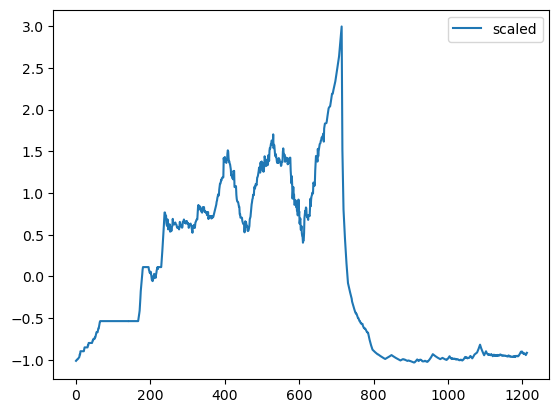

In [19]:
# Visualize scaled data
plt.plot(train['Close'], label = 'scaled')
plt.legend()
plt.show()

In [20]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []
    for i in range(len(X)-time_steps):
        X_out.append(X.iloc[i:(i+time_steps)].values)
        y_out.append(y.iloc[i+time_steps])
    
    return np.array(X_out), np.array(y_out)

X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test = create_sequences(test[['Close']], test['Close'])
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (1183, 30, 1)
Testing input shape:  (436, 30, 1)


In [21]:
X_train[1182]

array([[-0.9599269 ],
       [-0.952413  ],
       [-0.95541856],
       [-0.95491763],
       [-0.95642043],
       [-0.95191208],
       [-0.95842412],
       [-0.952413  ],
       [-0.95141116],
       [-0.94439818],
       [-0.93588244],
       [-0.92686576],
       [-0.91734815],
       [-0.90732963],
       [-0.90232036],
       [-0.91283983],
       [-0.9028213 ],
       [-0.90131853],
       [-0.90833149],
       [-0.91885095],
       [-0.92436113],
       [-0.92135558],
       [-0.92886948],
       [-0.92536298],
       [-0.92486205],
       [-0.92586391],
       [-0.93538151],
       [-0.94339633],
       [-0.93488057],
       [-0.92586391]])

In [22]:
# set seed to regenerate same sequence of random numbers. 
np.random.seed(21)
tf.random.set_seed(21)

In [39]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(X_train.shape[2])))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 30, 128)           66560     
                                                                 
 lstm_6 (LSTM)               (None, 30, 64)            49408     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 repeat_vector_1 (RepeatVec  (None, 30, 32)            0         
 tor)                                                            
                                                                 
 lstm_8 (LSTM)               (None, 30, 32)            8320      
                                                                 
 lstm_9 (LSTM)               (None, 30, 64)            24832     
                                                      

In [78]:
history = model.fit(X_train,
                    y_train,
                    epochs=200,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')],
                    shuffle=False)

Epoch 1/200
34/34 [==============================] - 4s 113ms/step - loss: 0.1446 - val_loss: 0.0027
Epoch 2/200
34/34 [==============================] - 3s 94ms/step - loss: 0.1426 - val_loss: 0.0031
Epoch 3/200
34/34 [==============================] - 3s 95ms/step - loss: 0.1411 - val_loss: 0.0025
Epoch 4/200
34/34 [==============================] - 3s 98ms/step - loss: 0.1454 - val_loss: 0.0025
Epoch 5/200
34/34 [==============================] - 3s 92ms/step - loss: 0.1474 - val_loss: 0.0031
Epoch 6/200
34/34 [==============================] - 3s 92ms/step - loss: 0.1544 - val_loss: 0.0037
Epoch 7/200
34/34 [==============================] - 3s 92ms/step - loss: 0.1465 - val_loss: 0.0032
Epoch 8/200
34/34 [==============================] - 3s 95ms/step - loss: 0.1425 - val_loss: 0.0025
Epoch 9/200
34/34 [==============================] - 3s 100ms/step - loss: 0.1431 - val_loss: 0.0027
Epoch 10/200
34/34 [==============================] - 3s 99ms/step - loss: 0.1404 - val_loss: 0.00

37/37 [==============================] - 1s 20ms/step
Reconstruction error threshold: 1.2407488492884688


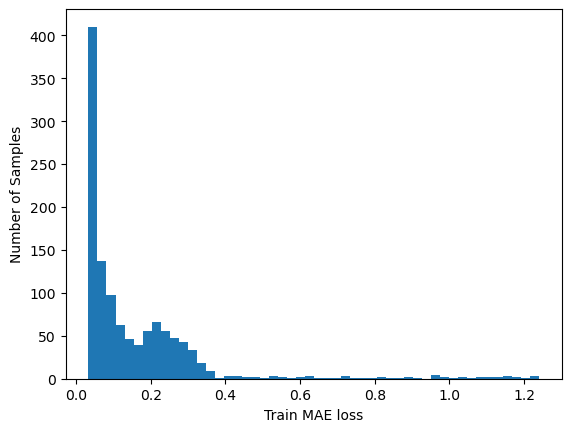

In [42]:
# Mean Absolute Error loss
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)

print('Reconstruction error threshold:',threshold)

14/14 [==============================] - 0s 20ms/step


Text(0, 0.5, 'Number of samples')

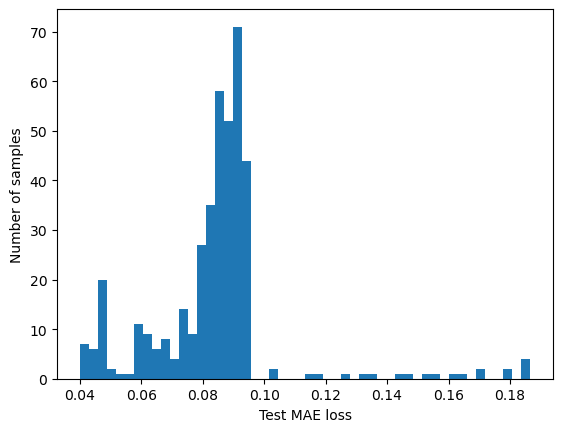

In [43]:
X_test_pred = model.predict(X_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [72]:
anomaly_df = pd.DataFrame(test[TIME_STEPS:])
anomaly_df['loss'] = test_mae_loss
anomaly_df['threshold'] = threshold
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']

In [73]:
anomaly_df.head()

,Date,Close,loss,threshold,anomaly
1243,2022-02-08,-0.695438,0.085751,1.240749,False
1244,2022-02-09,-0.692933,0.085153,1.240749,False
1245,2022-02-10,-0.684417,0.083899,1.240749,False
1246,2022-02-11,-0.681412,0.082530,1.240749,False
1247,2022-02-14,-0.702952,0.080865,1.240749,False


In [50]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies.head()

,Date,Close,loss,threshold,anomaly
1270,2022-03-21,-1.073136,0.183854,0.18,True
1271,2022-03-22,-1.074639,0.186106,0.18,True
1272,2022-03-23,-1.076643,0.186656,0.18,True
1273,2022-03-24,-1.078146,0.184072,0.18,True


In [51]:
anomalies.shape

(4, 5)

In [53]:
anomalies['Date']

1270    2022-03-21
1271    2022-03-22
1272    2022-03-23
1273    2022-03-24
Name: Date, dtype: object

In [79]:
model.save('my_model_v2.h5')